# Performance evaluation of Terapixel rendering in Cloud (Super)computing

In [ ]:
# !pip install sweetviz

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
# import sweetviz as sv
import IPython
from dateutil import parser
from datetime import datetime as dt, timedelta, date
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import chart_studio.plotly as py
import plotly.express as px
import plotly.io as pio
pio.renderers.default='notebook'

In [34]:
app_check = pd.read_csv("../data/application-checkpoints.csv")
gpu = pd.read_csv("../data/gpu.csv")
# task_xy = pd.read_csv("../data/task-x-y.csv")
app_conf_df = pd.read_csv("../data/processed_app_conf.csv")
event_total_duration_df = pd.read_csv("../data/event-total-duration.csv")
app_gpu = dd.read_csv("../data/app_gpu.csv")

In [20]:
app_conf_df.head()

Unnamed: 0                                hostname eventName  \
0           0  0d56a730076643d585f77e00d2d8521a00000N    Render   
1           1  0d56a730076643d585f77e00d2d8521a00000N    Render   
2           2  0d56a730076643d585f77e00d2d8521a00000N    Render   
3           3  0d56a730076643d585f77e00d2d8521a00000N    Render   
4           4  0d56a730076643d585f77e00d2d8521a00000N    Render   

                                             jobId  \
0  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
1  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
2  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
3  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
4  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   

                                 taskId            START             STOP  \
0  20fb9fcf-a927-4a4b-a64c-70258b66b42d  07:42:29.845000  07:43:10.965000   
1  e7776af5-510d-4ec4-b2d3-222b5df3307b  08:14:53.364000  08:15:32.380000   
2  339d3724-dcf6-41f1-b30d-c71107befcee  08:21:58.845000  08:22:38.257000   
3  8d663dcb-7a8c-42e9-93de-21d0e6a508f5  07:48:06.922000  07:48:47.993000   
4  244fd4f0-104e-4512-93b4-d9f83e2d0d9c  07:59:32.698000  08:00:11.667000   

   duration  
0    41.120  
1    39.016  
2    39.412  
3    41.071  
4    38.969

In [ ]:
app_check.head()

timestamp  ...                                taskId
0  2018-11-08T07:41:55.921Z  ...  b47f0263-ba1c-48a7-8d29-4bf021b72043
1  2018-11-08T07:42:29.842Z  ...  20fb9fcf-a927-4a4b-a64c-70258b66b42d
2  2018-11-08T07:42:29.845Z  ...  20fb9fcf-a927-4a4b-a64c-70258b66b42d
3  2018-11-08T07:42:29.845Z  ...  20fb9fcf-a927-4a4b-a64c-70258b66b42d
4  2018-11-08T07:43:13.957Z  ...  20fb9fcf-a927-4a4b-a64c-70258b66b42d

[5 rows x 6 columns]

In [ ]:
app_check.shape

(660400, 6)

In [ ]:
gpu.head()

timestamp  ... gpuMemUtilPerc
0  2018-11-08T08:27:10.314Z  ...             53
1  2018-11-08T08:27:10.192Z  ...             48
2  2018-11-08T08:27:10.842Z  ...             44
3  2018-11-08T08:27:10.424Z  ...             43
4  2018-11-08T08:27:10.937Z  ...             47

[5 rows x 8 columns]

In [5]:
gpu['gpuSerial'].nunique()

1024

In [ ]:
gpu.shape

(1543681, 8)

In [ ]:
task_xy.head()

taskId  ... level
0  00004e77-304c-4fbd-88a1-1346ef947567  ...    12
1  0002afb5-d05e-4da9-bd53-7b6dc19ea6d4  ...    12
2  0003c380-4db9-49fb-8e1c-6f8ae466ad85  ...    12
3  000993b6-fc88-489d-a4ca-0a44fd800bd3  ...    12
4  000b158b-0ba3-4dca-bf5b-1b3bd5c28207  ...    12

[5 rows x 5 columns]

In [ ]:
task_xy.shape

(65793, 5)

In [ ]:
app_check.value_counts("eventName")

eventName
Uploading        132080
TotalRender      132080
Tiling           132080
Saving Config    132080
Render           132080
dtype: int64

Text(0.5, 1.0, 'Power Draw vs Temperature of the GPU')

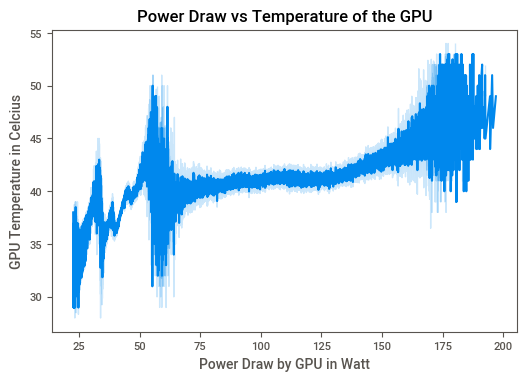

In [ ]:
ax = sns.lineplot(data=gpu, x="powerDrawWatt", y="gpuTempC")
plt.xlabel('Power Draw by GPU in Watt')
plt.ylabel('GPU Temperature in Celcius')
plt.title("Power Draw vs Temperature of the GPU")
plt.show()

In [ ]:
px.line(gpu, x="powerDrawWatt", y="gpuTempC")

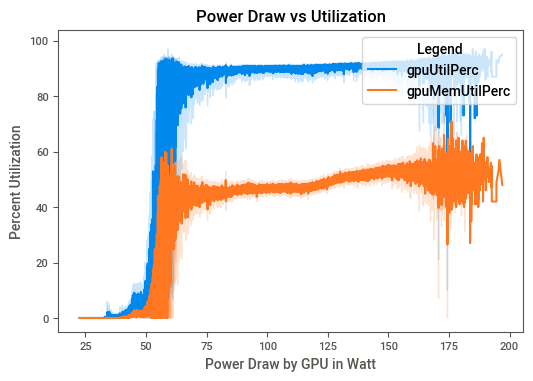

In [ ]:
ax = sns.lineplot(data=pd.melt(gpu[["powerDrawWatt", "gpuUtilPerc", "gpuMemUtilPerc"]], 'powerDrawWatt'), x="powerDrawWatt", y="value", hue = "variable")
plt.xlabel('Power Draw by GPU in Watt')
plt.ylabel('Percent Utilization')
plt.title("Power Draw vs Utilization")
plt.legend(loc='upper right', title='Legend')
plt.show()

In [17]:
app_gpu = app_gpu.reset_index()

In [21]:
del app_gpu['Unnamed: 0']

In [24]:
type(app_gpu)

dask.dataframe.core.DataFrame

In [5]:
gpu['gpuSerial'] = gpu['gpuSerial'].astype(str)

In [6]:
gpu_powerdraw = gpu[['gpuSerial', 'powerDrawWatt']].groupby(['gpuSerial']).mean()

In [7]:
gpu_powerdraw.index.names = ['gpuSerial']
gpu_powerdraw.reset_index(inplace=True)

In [10]:
gpu_powerdraw.columns

Index(['gpuSerial', 'powerDrawWatt'], dtype='object')

In [32]:
px.line(gpu_powerdraw, x="gpuSerial", y="powerDrawWatt")

In [33]:
event_total_duration_df

Unnamed: 0      eventName  totalDuration
0           0         Tiling         761.96
1           1  Saving Config           0.05
2           2         Render          17.99
3           3    TotalRender         787.77
4           4      Uploading          25.75

In [39]:
# fig, ax = plt.subplots(figsize=(12, 7))
# sns.barplot(data=event_total_duration_df, x="eventName", y="totalDuration", order=['Render', 'Saving Config', 'Tiling', 'TotalRender', 'Uploading'])
# plt.xlabel('Event Name', fontsize = 15)
# plt.ylabel('Total Time taken', fontsize = 15)
# plt.title("Total time taken by each event in hrs", fontsize = 15)
# plt.show()

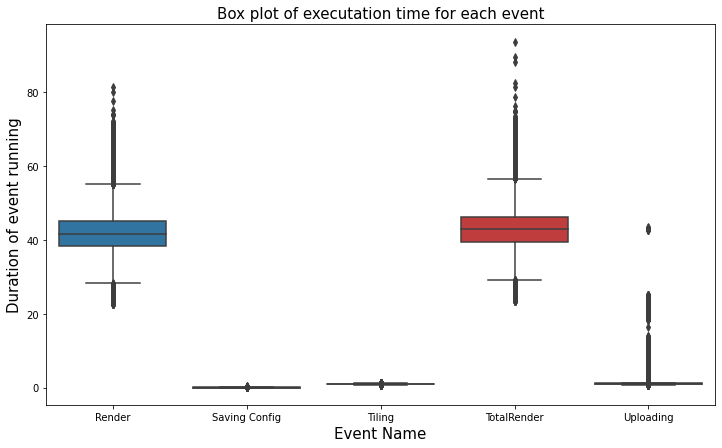

In [38]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(x="eventName", y="duration", data=app_conf_df)
plt.xlabel('Event Name', fontsize = 15)
plt.ylabel('Duration of event running', fontsize = 15)
plt.title("Box plot of executation time for each event", fontsize = 15)
plt.show()

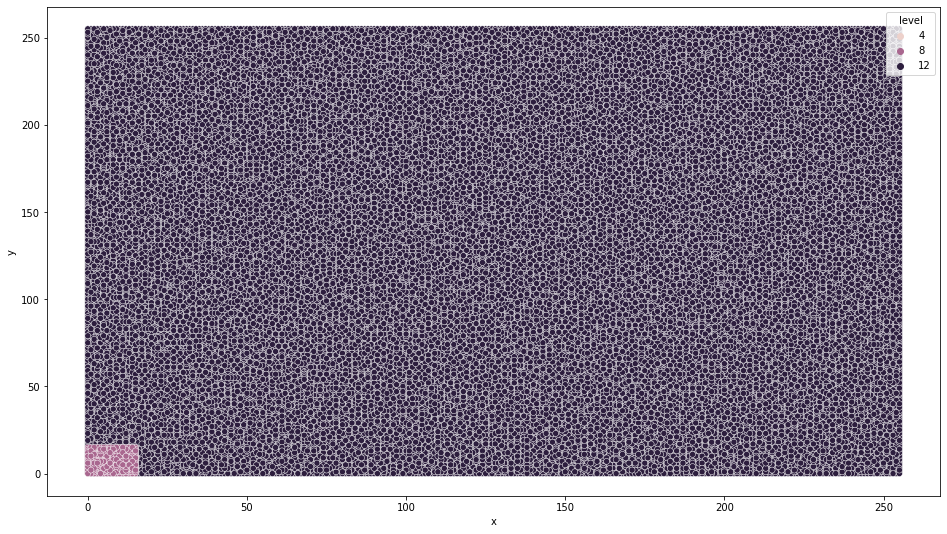

In [28]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.scatterplot(data=task_xy, x="x", y="y", hue = 'level')
plt.show()

In [32]:
app_gpu.head()

Unnamed: 0                                hostname eventName  \
0           0  0d56a730076643d585f77e00d2d8521a00000N    Render   
1           0  0d56a730076643d585f77e00d2d8521a00000N    Render   
2           0  0d56a730076643d585f77e00d2d8521a00000N    Render   
3           0  0d56a730076643d585f77e00d2d8521a00000N    Render   
4           0  0d56a730076643d585f77e00d2d8521a00000N    Render   

                                             jobId  \
0  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
1  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
2  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
3  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   
4  1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705   

                                 taskId            START             STOP  \
0  20fb9fcf-a927-4a4b-a64c-70258b66b42d  07:42:29.845000  07:43:10.965000   
1  20fb9fcf-a927-4a4b-a64c-70258b66b42d  07:42:29.845000  07:43:10.965000   
2  20fb9fcf-a927-4a4b-a64c-70258b66b42d  07:42:29.845000  07:43:10.965000   
3  20fb9fcf-a927-4a4b-a64c-70258b66b42d  07:42:29.845000  07:43:10.965000   
4  20fb9fcf-a927-4a4b-a64c-70258b66b42d  07:42:29.845000  07:43:10.965000   

   duration                 timestamp     gpuSerial  \
0      0.01  2018-11-08T07:41:30.822Z  325217086221   
1      0.01  2018-11-08T07:41:46.962Z  325217086221   
2      0.01  2018-11-08T07:41:48.979Z  325217086221   
3      0.01  2018-11-08T07:41:55.034Z  325217086221   
4      0.01  2018-11-08T07:41:57.053Z  325217086221   

                                    gpuUUID  powerDrawWatt  gpuTempC  \
0  GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f          26.69        29   
1  GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f          76.34        33   
2  GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f          68.88        33   
3  GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f          46.18        32   
4  GPU-1265fef9-aea4-4a5e-8a63-cc5af7b19f4f          29.29        32   

   gpuUtilPerc  gpuMemUtilPerc  
0            0               0  
1           84              33  
2           83              33  
3            0               0  
4            0               0

In [15]:
app_gpu['jobId'].compute().nunique()

3

In [16]:
app_gpu['taskId'].compute().nunique()

65793

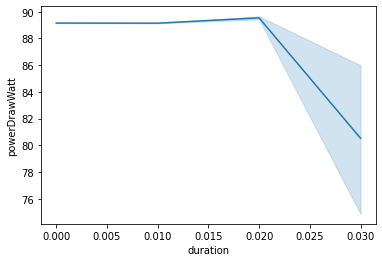

In [4]:
frac = 0.1
sns.lineplot(data = app_gpu.sample(frac=frac), x = "duration", y = "powerDrawWatt")
plt.show()

In [8]:
render_df = app_gpu[app_gpu['eventName'] == 'Render']

<AxesSubplot:xlabel='duration', ylabel='powerDrawWatt'>

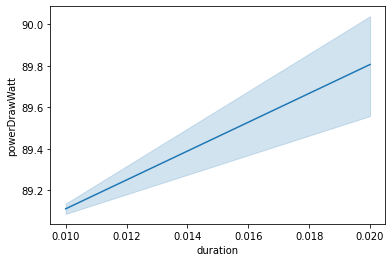

In [10]:
sns.lineplot(data = render_df.sample(frac=frac), x = "duration", y = "powerDrawWatt")